In [2]:
import numpy as np
from scipy.io import readsav
import copy
import pandas as pd

In [3]:
import numpy as np
import copy
from tqdm import tqdm
# Definir vr y vx
vr = np.array([0.07025444373403009, 0.14139327496887916, 0.21341649370454718, 
               0.2863240999410342, 0.3601160936783402, 0.43479247491646505, 
               0.510353243655409, 0.5867983998951719, 0.6641279436357537, 
               0.7423418748771545, 0.8214401936193743, 0.901422899862413, 
               0.9822899936062708, 1.0640414748509475, 1.146677343596443, 
               1.230197599842758, 1.3146022435898914, 1.3998912748378438, 
               1.4860646935866155, 1.5731224998362061, 1.6610646935866153, 
               1.749891274837844, 1.8396022435898913, 1.9301975998427576, 
               2.0216773435964432, 2.1140414748509473, 2.207289993606271, 
               2.301422899862413, 2.396440193619374, 2.4923418748771544, 
               2.5891279436357535, 2.6867983998951717, 2.785353243655409, 
               2.8847924749164653, 2.9851160936783403, 3.086324099941034, 
               3.1884164937045467, 3.291393274968879, 3.39525444373403, 3.5])

vx = np.array([-3.5, -3.39525444373403, -3.291393274968879, -3.1884164937045467, 
               -3.086324099941034, -2.9851160936783403, -2.8847924749164653, 
               -2.785353243655409, -2.6867983998951717, -2.5891279436357535, 
               -2.4923418748771544, -2.396440193619374, -2.301422899862413, 
               -2.207289993606271, -2.1140414748509473, -2.0216773435964432, 
               -1.9301975998427576, -1.8396022435898913, -1.749891274837844, 
               -1.6610646935866153, -1.5731224998362061, -1.4860646935866155, 
               -1.3998912748378438, -1.3146022435898914, -1.230197599842758, 
               -1.146677343596443, -1.0640414748509475, -0.9822899936062708, 
               -0.901422899862413, -0.8214401936193743, -0.7423418748771545, 
               -0.6641279436357537, -0.5867983998951719, -0.510353243655409, 
               -0.43479247491646505, -0.3601160936783402, -0.2863240999410342, 
               -0.21341649370454718, -0.14139327496887916, -0.07025444373403009, 
               0.07025444373403009, 0.14139327496887916, 0.21341649370454718, 
               0.2863240999410342, 0.3601160936783402, 0.43479247491646505, 
               0.510353243655409, 0.5867983998951719, 0.6641279436357537, 
               0.7423418748771545, 0.8214401936193743, 0.901422899862413, 
               0.9822899936062708, 1.0640414748509475, 1.146677343596443, 
               1.230197599842758, 1.3146022435898914, 1.3998912748378438, 
               1.4860646935866155, 1.5731224998362061, 1.6610646935866153, 
               1.749891274837844, 1.8396022435898913, 1.9301975998427576, 
               2.0216773435964432, 2.1140414748509473, 2.207289993606271, 
               2.301422899862413, 2.396440193619374, 2.4923418748771544, 
               2.5891279436357535, 2.6867983998951717, 2.785353243655409, 
               2.8847924749164653, 2.9851160936783403, 3.086324099941034, 
               3.1884164937045467, 3.291393274968879, 3.39525444373403, 3.5])

''' 
Version 01
Authors: Julio Balbin, Carlo Becerra
Date: August 17th, 2024
'''
def Make_dVr_dVx(vr: np.ndarray
                ,vx: np.ndarray):
    ''' 
    vr & vx are from:
    -> 1090904024_950to1050.sav

    Constructs velocity space differentials for distribution functions
    used by Kinetic_Neutrals.pro, Kinetic_H2.pro, Kinetic_H2.pro

    The abs(difference) between vol variable in python & IDL is in the range: 
    <(np.float64(1.433306555442826e-06), np.float64(6.70904781382986e-12)>
    '''

    # nvr & nvx are taking the shape of vr & vx respectively
    nvr = vr.size
    nvx = vx.size

    # Calculations for r-dimension
    _vr     = np.append(vr, 2 * vr[-1] - vr[-2])
    vr_mid  = np.concatenate(([0.0], 0.5 * (_vr + np.roll(_vr, -1))))

    vrR = np.roll(vr_mid, -1)[0:nvr]
    vrL = copy.copy(vr_mid)[0:nvr]

    Vr2pidVr    =         np.pi * (vrR**2 - vrL**2)
    VrVr4pidVr  = (4/3) * np.pi * (vrR**3 - vrL**3)

    # Calculations for x-dimension
    _vx = np.concatenate(([2 * vx[0] - vx[1]], vx, [2 * vx[-1] - vx[-2]]))

    vxR = 0.5 * (np.roll(_vx, -1) + _vx)[1:nvx+1]
    vxL = 0.5 * (np.roll(_vx,  1) + _vx)[1:nvx+1]

    dVx = vxR - vxL

    # Calc. volumen
    vol = np.zeros((nvr, nvx), dtype=np.float64)
    for i in tqdm(range(nvr), desc=f"Make_dVr_dVx: calc. vol"): 
        vol[i, :] = Vr2pidVr[i] * dVx
        
    Deltavx = vxR - vxL
    Deltavr = vrR - vrL

    vth_Deltavx =np.zeros((nvr+2,nvx+2),dtype = np.float64)
    vx_Deltavx  =np.zeros((nvr+2,nvx+2),dtype = np.float64)
    vr_Deltavr  =np.zeros((nvr+2,nvx+2),dtype = np.float64)

    for j in tqdm(range(1,nvr+1),desc=f"Make_dVr_dVx: calc. vth & vx"):
        vth_Deltavx[j,1:nvx+1] = 1.0/Deltavx    # vth_Deltavx(i,1:nvx)=1.0/Deltavx
        vx_Deltavx[ j,1:nvx+1] =  vx/Deltavx     #  vx_Deltavx(i,1:nvx)= vx/Deltavx

    for k in tqdm(range(1,nvx+1),desc=f"Make_dVr_dVx: calc. vr"):
        vr_Deltavr[ 1:nvr+1,k] =  vr/Deltavr     #  vr_Deltavr(1:nvr,j)=vr/Deltavr
    
    # Compute v^2
    vr2vx2=np.zeros((nvr,nvx), dtype=np.float64)
    for l in range(0,nvr):
        vr2vx2[l,:] = vr[l]**2 + vx**2

    # vx's positive index
    jp = copy.copy(np.where(vx>0)[0])   # This saves the positives index of vx
    jpa = int(jp[0])                    # This saves the first index of jp
    jpb = int(jp[len(jp)-1])            # This saves the last index of jp

    # vx's negative index   
    jn = copy.copy(np.where(vx<0)[0])   # This saves the negatives index of vx
    jna = int(jn[0])                    # This saves the first index of jp
    jnb = int(jn[len(jn)-1])            # This saves the last index of jp

    return Vr2pidVr, VrVr4pidVr,dVx,vrL,vrR,vxL,vxR,\
           vol,vth_Deltavx,vx_Deltavx,vr_Deltavr,vr2vx2,\
           jpa,jpb,jna,jnb

Vr2pidVr, VrVr4pidVr,dVx,vrL,vrR,vxL,vxR,\
    vol,vth_Deltavx,vx_Deltavx,vr_Deltavr,vr2vx2,\
    jpa,jpb,jna,jnb = Make_dVr_dVx(vr,vx)

Make_dVr_dVx: calc. vr: 100%|██████████| 80/80 [00:00<?, ?it/s]


In [ ]:
vr = np.array([0.07025444373403009, 0.14139327496887916, 0.21341649370454718,  
      0.2863240999410342, 0.3601160936783402, 0.43479247491646505,  
      0.510353243655409, 0.5867983998951719, 0.6641279436357537,  
      0.7423418748771545, 0.8214401936193743, 0.901422899862413,  
      0.9822899936062708, 1.0640414748509475, 1.146677343596443,  
      1.230197599842758, 1.3146022435898914, 1.3998912748378438,  
      1.4860646935866155, 1.5731224998362061, 1.6610646935866153,  
      1.749891274837844, 1.8396022435898913, 1.9301975998427576,  
      2.0216773435964432, 2.1140414748509473, 2.207289993606271,  
      2.301422899862413, 2.396440193619374, 2.4923418748771544,  
      2.5891279436357535, 2.6867983998951717, 2.785353243655409,  
      2.8847924749164653, 2.9851160936783403, 3.086324099941034,  
      3.1884164937045467, 3.291393274968879, 3.39525444373403, 3.5]
)
vx = np.array([-3.5, -3.39525444373403, -3.291393274968879, -3.1884164937045467,  
      -3.086324099941034, -2.9851160936783403, -2.8847924749164653,  
      -2.785353243655409, -2.6867983998951717, -2.5891279436357535,  
      -2.4923418748771544, -2.396440193619374, -2.301422899862413,  
      -2.207289993606271, -2.1140414748509473, -2.0216773435964432,  
      -1.9301975998427576, -1.8396022435898913, -1.749891274837844,  
      -1.6610646935866153, -1.5731224998362061, -1.4860646935866155,  
      -1.3998912748378438, -1.3146022435898914, -1.230197599842758,  
      -1.146677343596443, -1.0640414748509475, -0.9822899936062708,  
      -0.901422899862413, -0.8214401936193743, -0.7423418748771545,  
      -0.6641279436357537, -0.5867983998951719, -0.510353243655409,  
      -0.43479247491646505, -0.3601160936783402, -0.2863240999410342,  
      -0.21341649370454718, -0.14139327496887916, -0.07025444373403009,  
      0.07025444373403009, 0.14139327496887916, 0.21341649370454718,  
      0.2863240999410342, 0.3601160936783402, 0.43479247491646505,  
      0.510353243655409, 0.5867983998951719, 0.6641279436357537,  
      0.7423418748771545, 0.8214401936193743, 0.901422899862413,  
      0.9822899936062708, 1.0640414748509475, 1.146677343596443,  
      1.230197599842758, 1.3146022435898914, 1.3998912748378438,  
      1.4860646935866155, 1.5731224998362061, 1.6610646935866153,  
      1.749891274837844, 1.8396022435898913, 1.9301975998427576,  
      2.0216773435964432, 2.1140414748509473, 2.207289993606271,  
      2.301422899862413, 2.396440193619374, 2.4923418748771544,  
      2.5891279436357535, 2.6867983998951717, 2.785353243655409,  
      2.8847924749164653, 2.9851160936783403, 3.086324099941034,  
      3.1884164937045467, 3.291393274968879, 3.39525444373403, 3.5])
vx_shift = [0.0]
Tmaxwell = [0.02524895]
mol = 2
mu  = 2.0
q   = 1.602177e-19
mH  = 1.6726231e-27
Tnorm = 74.317975



In [5]:
nvr = len(vr)
nvx = len(vx)
nx = len(vx_shift)
vth=np.sqrt(2*q*Tnorm/(mu*mH))
print(vth)

84372.93078875131


In [6]:
vth2=vth*vth
print(vth2)

7118791449.883419


In [7]:
AN = np.zeros((nvr,nvx,2), dtype=np.float64)
BN = np.zeros((nvr,nvx,2), dtype=np.float64)
maxwell = np.zeros((nvr,nvx,nx),dtype=np.float32)
sgn=[1,-1]
print(maxwell.shape)

(40, 80, 1)


In [8]:
import sympy as sp
sp.Matrix([1, 2]).dot(sp.Matrix([3, 4]))

11

In [9]:
vx_Deltavx

array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        , -33.41430534, -32.55172568, ...,  32.55172568,
         33.41430534,   0.        ],
       [  0.        , -33.41430534, -32.55172568, ...,  32.55172568,
         33.41430534,   0.        ],
       ...,
       [  0.        , -33.41430534, -32.55172568, ...,  32.55172568,
         33.41430534,   0.        ],
       [  0.        , -33.41430534, -32.55172568, ...,  32.55172568,
         33.41430534,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [10]:
# from scipy.linalg import blas
# result = blas.sgemm(alpha=1.0, a=maxwell[:, :, k], b=(vx * dVx), trans_b=False)
# print(result)

In [44]:
import matplotlib.pyplot as plt
for k in range(nx):
    if Tmaxwell[k]>0.0:
        for i in range(nvr):
            arg = -((vr[i]**2 + ((vx) - (vx_shift[k] / vth))**2) * mol * Tnorm / Tmaxwell[k])  # Error de \pm 3e-3
            arg = np.where(np.logical_and((-80 < arg),(arg < 0.0)), arg, -80)
            maxwell[i,:,k] = np.exp(arg)
        # maxwell[:,:,k] = copy.copy(maxwell[:,:,k]/(np.nansum(Vr2pidVr*np.matmul(maxwell[:,:,k],dVx.T))))
        variable = np.array(sp.Matrix(maxwell[:, :, k]) * sp.Matrix(dVx), dtype=float).flatten()
        maxwell[:,:,k] = copy.copy(maxwell[:,:,k]/(np.nansum(Vr2pidVr*variable)))
        # print(maxwell[:,:,k].max())
        # Compute desired moments
        WxD = copy.copy(vx_shift[k])
        # print('WxD:',WxD)
        ED = (WxD**2)+3*q*(Tmaxwell[k])/(mol*mu*mH)
        # print('ED:',ED)
        # Compute present moments of Maxwell, WxMax, and EMax 
        vx_dvx = vx*dVx
        # maxwell = maxwell.astype(np.float64)
        # print(np.matmul(maxwell[:, :, k], (vx * dVx)))
        # result = np.sum(maxwell[:, :, k] * np.expand_dims(vx * dVx, axis=0), axis=1)
        # print(result)
        maxwell_2d = copy.copy(maxwell[:, :, k])
        # print(maxwell_2d.shape)
        # print(np.matmul(maxwell_2d,vx_dvx))
        # print(np.matmul(maxwell[:, :, k], (vx * dVx)))
        # print(Vr2pidVr)

        # df = pd.DataFrame(maxwell[:,:,k])
        # vector = pd.Series(vx_dvx)

        # print(df.dot(vector))

        # print(maxwell[:, :, k].dot((vx*dVx).T))
        # print(np.array(sp.Matrix(maxwell[:, :, k]) * sp.Matrix(vx * dVx), dtype=float).flatten())
        # print(sp.Matrix(vx * dVx).shape)
        # print((sp.Matrix(maxwell[:, :, k]) * sp.Matrix(vx * dVx)).shape)
        max_2d_xd = np.array(sp.Matrix(maxwell[:, :, k]) * sp.Matrix(vx * dVx), dtype=float).flatten()
        # print(max_2d_xd)
        # print(np.array(np.matrix(maxwell[:, :, k]*np.matrix(vx * dVx).T), dtype=float).flatten())
        # print(np.nansum(Vr2pidVr * (np.matmul(maxwell[:, :, k], (vx * dVx),dtype=np.float64)) ))
        # WxMax = vth * (np.nansum(Vr2pidVr * (np.matmul(maxwell[:, :, k], (vx * dVx),dtype=np.float64)) ))
        WxMax = vth * (np.nansum(Vr2pidVr * (max_2d_xd) ))
        # print('WxMax:',WxMax)
        EMax=vth2*(np.nansum(Vr2pidVr*(np.matmul((vr2vx2*maxwell[:,:,k]),dVx))))
        # print('EMax:',EMax)


        # Compute Nij from Maxwell, padded with zeros
        Nij = np.zeros((nvr+2,nvx+2), dtype=np.float64)  # The order of the error is maintained with float64, but not for float 32
        Nij[1:nvr+1,1:nvx+1] = maxwell[:,:,k]*vol
        auxNij = Nij*vx_Deltavx
        Nijp1_vx_Dvx = np.roll(auxNij, shift=-1, axis=1)
        Nij_vx_Dvx  =Nij*vx_Deltavx
        Nijm1_vx_Dvx = np.roll(auxNij, shift=1, axis=1)
        auxNij2 = Nij*vr_Deltavr
        Nip1j_vr_Dvr = np.roll(auxNij2, shift=-1,axis=0 )
        Nij_vr_Dvr   =Nij*vr_Deltavr
        Nim1j_vr_Dvr = np.roll(auxNij2, shift=1, axis=0)
        
        
        
        # Compute Ap, Am, Bp, and Bm (0=p 1=m)
        aux_AN = np.zeros((nvx+2,nvr+2),dtype=np.float64)
        aux_AN = Nij*vth_Deltavx

        _AN = np.zeros((nvx+2,nvr+2), dtype=np.float64)
        _AN = np.roll(aux_AN, shift=1, axis=1) - aux_AN
        
        AN[:,:,0] = copy.copy(_AN[1:nvr+1,1:nvx+1])
 
        _AN = np.zeros((nvx+2,nvr+2), dtype=np.float64)
        _AN = -np.roll(aux_AN, shift=-1, axis=1) + aux_AN

        AN[:,:,1] = copy.copy(_AN[1:nvr+1,1:nvx+1])

        # print(AN[:,:,1].shape)
        # np.savetxt('salida.dat', AN[:,:,1], fmt='%.4e',delimiter='\t')

        BN[:,jpa+1:jpb+1,0] = Nijm1_vx_Dvx[1:nvr+1,jpa+2:jpb+2] - Nij_vx_Dvx[1:nvr+1,jpa+2:jpb+2]
        BN[:,jpa,0] = -Nij_vx_Dvx[1:nvr+1,jpa+1]
        BN[:,jnb,0] =  Nij_vx_Dvx[1:nvr+1,jnb+1]
        BN[:,jna:jnb,0] = -Nijp1_vx_Dvx[1:nvr+1,jna+1:jnb+1] + Nij_vx_Dvx[1:nvr+1,jna+1:jnb+1]
        BN[:,:,0]   = BN[:,:,0] + Nim1j_vr_Dvr[1:nvr+1,1:nvx+1] - Nij_vr_Dvr[1:nvr+1,1:nvx+1]
        


        BN[:,jpa+1:jpb+1,1] = -Nijp1_vx_Dvx[1:nvr+1,jpa+2:jpb+2] + Nij_vx_Dvx[1:nvr+1,jpa+2:jpb+2]
        BN[:,jpa,1] = -Nijp1_vx_Dvx[1:nvr+1,jpa+1]
        BN[:,jnb,1] =  Nijm1_vx_Dvx[1:nvr+1,jnb+1]
        BN[:,jna:jnb,1] = Nijm1_vx_Dvx[1:nvr+1,jna+1:jnb+1] - Nij_vx_Dvx[1:nvr+1,jna+1:jnb+1]
        BN[1:nvr,:,1] = BN[1:nvr,:,1] - Nip1j_vr_Dvr[2:nvr+1,1:nvx+1] + Nij_vr_Dvr[2:nvr+1,1:nvx+1]
        BN[0,:,1] = BN[0,:,1] - Nip1j_vr_Dvr[1,1:nvx+1]
        # np.savetxt('salida.dat', BN[:,:,0], fmt='%.4e',delimiter='\t')
        # print(BN.shape)


        # Remove padded zeros in Nij
        Nij = Nij[1:nvr+1,1:nvx+1]
        # print(Nij.shape)
        # np.savetxt('salida.dat', Nij, fmt='%.4e',delimiter='\t')

        # Cycle through 4 possibilies of sign(a_Max),sign(b_Max)
        TB1 = np.zeros(2)#, dtype=np.float32)
        TB2 = np.zeros(2)#, dtype=np.float32)
        # print(type(TB1))
        ia=0
        while ia<2:
            # Compute TA1, TA2    
            aux_TA1 = np.array(sp.Matrix(AN[:,:,ia]*sp.Matrix(vx)),dtype=float).flatten()
            TA1 = vth*np.sum(aux_TA1)
            print(TA1)
            # TA1 = vth*np.sum(AN[:,:,ia]*vx)
            TA2 = vth2*np.sum(vr2vx2*AN[:,:,ia])
            ib=0
            while ib<2:
                # Compute TB1, TB2
                if TB1[ib]==0:
                    aux_TB1 = np.array(sp.Matrix(BN[:,:,ib])*sp.Matrix(vx),dtype=float).flatten()
                    # TB1[ib] = vth*np.sum(BN[:,:,ib]*vx)
                    TB1[ib] = vth*np.sum(aux_TB1)
                    print('TB1:',TB1, 'ib:',ib)
                if TB2[ib]==0:
                    TB2[ib] = vth2*np.sum(vr2vx2*BN[:,:,ib])
                denom = TA2*TB1[ib]-TA1*TB2[ib]
                print('denom:',denom, 'ib:',ib)
                b_Max = 0.0
                a_Max = 0.0
                if denom!=0 and TA1 !=0:
                    b_Max = (TA2*(WxD-WxMax) - TA1*(ED-EMax))/denom
                    a_Max = (WxD-WxMax-TB1[ib]*b_Max)/TA1
                    # print('WxD:',WxD)
                    # print('WxMax:',WxMax)
                if a_Max*sgn[ia] > 0 and b_Max*sgn[ib]>0:
                    maxwell[:,:,k] = (Nij + AN[:,:,ia]*a_Max + BN[:,:,ib]*b_Max)/vol
                    np.savetxt('salida_23.dat', maxwell[:,:,k], fmt='%.4e',delimiter='\t')
                    ia=2
                    ib=2
                ib = ib+1
            ia=ia+1

        aux_maxwell = np.array(sp.Matrix(maxwell[:,:,k])*sp.Matrix(dVx),dtype=float).flatten()
        maxwell[:,:,k] = maxwell[:,:,k]/np.sum(Vr2pidVr*aux_maxwell)
        print(maxwell[:,:,k].shape)
        np.savetxt('salida.dat', maxwell[:,:,k], fmt='%.4e',delimiter='\t')
                    
        
        

84372.42723949559
TB1: [1.28950102e-13 0.00000000e+00] ib: 0
denom: -11788422308118.031 ib: 0
TB1: [ 1.28950102e-13 -2.67999946e-17] ib: 1
denom: -145461001427.47366 ib: 1
(40, 80)


In [12]:
import numpy as np

demo_shift2 = np.array([
    [-91, 0, 2, 89, -1],
    [3, 20, 5, 26, 31],
    [-51, 70, 32, 78, -50],
    [123, 234, 345, 456, 567]
])
# Ejemplo 1: Desplazar 1 posición hacia la izquierda (dimensión 1)
result1 = np.roll(demo_shift2, shift=-1, axis=1)
result1 = np.roll(result1, shift=1, axis=0)
# Ejemplo 2: Desplazar 1 posición hacia abajo (dimensión 2)
result2 = np.roll(demo_shift2, shift=1, axis=0)
# Ejemplo 3: Desplazar 1 posición en ambas dimensiones
result3 = np.roll(demo_shift2, shift=0, axis=1)
result3 = np.roll(result3, shift=-1, axis=0)
print(result1)
print('#')
print(result2)
print('#')
print(result3)

[[234 345 456 567 123]
 [  0   2  89  -1 -91]
 [ 20   5  26  31   3]
 [ 70  32  78 -50 -51]]
#
[[123 234 345 456 567]
 [-91   0   2  89  -1]
 [  3  20   5  26  31]
 [-51  70  32  78 -50]]
#
[[  3  20   5  26  31]
 [-51  70  32  78 -50]
 [123 234 345 456 567]
 [-91   0   2  89  -1]]


In [13]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
number = 3.9051036573634155e-18
complement = 1.0 - number
print(complement)


1.0


In [24]:
d = np.array([[1,2,3],[30,40,50],[200,300,500]])
e = np.array([[-1,-2,-3],[-30,-40,-50],[-200,-300,-500]])
f = np.array([-10,-20,-30])
d*e
print(d*f)

[[   -10    -40    -90]
 [  -300   -800  -1500]
 [ -2000  -6000 -15000]]


In [26]:
sp.Matrix(d)*sp.Matrix(f) 

Matrix([
[  -140],
[ -2600],
[-23000]])

In [22]:
np.asmatrix(d).dot(np.asmatrix(e))

matrix([[   -661,    -982,   -1603],
        [ -11230,  -16660,  -27090],
        [-109200, -162400, -265600]])

In [ ]:
max_idl = [
    -1.2140179e-17, -2.6675281e-23, -2.6675281e-23, -2.6675281e-23, -2.6675281e-23,
    -2.6675281e-23, -2.6675281e-23, -2.6675281e-23, -2.6675281e-23, -2.6675281e-23,
    -2.6675281e-23, -2.6675281e-23, -2.6675281e-23, -2.6675281e-23, -2.6675281e-23,
    -2.6675281e-23, -2.6675281e-23, -2.6675281e-23, -2.6675281e-23, -2.6675281e-23,
    -2.6675281e-23, -2.6675281e-23, -2.6675281e-23, -2.6675281e-23, -2.6675281e-23,
    -2.6675281e-23, -2.6675281e-23, -2.6675281e-23, -2.6675281e-23, -2.6675281e-23,
    -2.6675281e-23, -2.6675281e-23, -2.6675281e-23, -2.6675281e-23, -2.6675281e-23,
    -2.6675281e-23, -2.6675281e-23, -2.6675281e-23, -2.6675281e-23, -2.6675281e-23
]
max_py = np.matmul(maxwell[:, :, k], (vx * dVx))

np.float64(1.2316248146251566e-16)

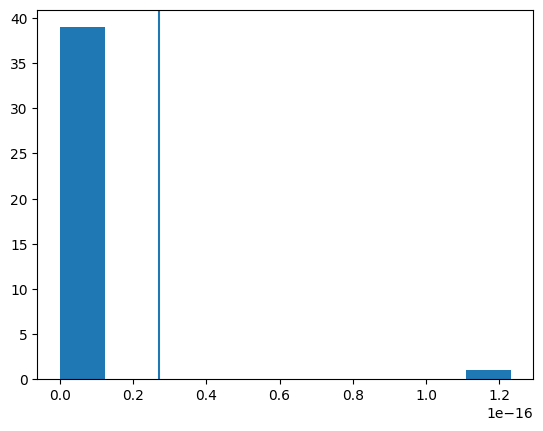

In [ ]:
plt.hist(max_py-max_idl)
plt.axvline(np.quantile(max_py-max_idl,0.98))
np.max(max_py-max_idl)

In [ ]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
vx*dVx

In [ ]:
shifted_maxwellian_debug=0

In [ ]:
from scipy.io import readsav
matrix_40x80 = readsav('matrix_40x80.sav')
m40_x80 = matrix_40x80['matrix'].T

In [ ]:
m40_x80 = copy.copy(m40_x80.flatten())

In [ ]:
maxwell[:,:,k].shape

In [ ]:
np.where(maxwell[:,:,k].flatten()==np.max(maxwell[:,:,k].flatten()))
# np.where(m40_x80==np.max(m40_x80))

In [ ]:
mpy40x80 = copy.copy(maxwell[:,:,k].flatten())
plt.hist(mpy40x80-m40_x80)
plt.axvline(np.quantile(mpy40x80-m40_x80,0.98))
(mpy40x80-m40_x80).max()

In [ ]:
mpy40x80.max()

In [ ]:
import numpy as np
import copy
from tqdm import tqdm
# Definir vr y vx
vr = np.array([0.07025444373403009, 0.14139327496887916, 0.21341649370454718, 
               0.2863240999410342, 0.3601160936783402, 0.43479247491646505, 
               0.510353243655409, 0.5867983998951719, 0.6641279436357537, 
               0.7423418748771545, 0.8214401936193743, 0.901422899862413, 
               0.9822899936062708, 1.0640414748509475, 1.146677343596443, 
               1.230197599842758, 1.3146022435898914, 1.3998912748378438, 
               1.4860646935866155, 1.5731224998362061, 1.6610646935866153, 
               1.749891274837844, 1.8396022435898913, 1.9301975998427576, 
               2.0216773435964432, 2.1140414748509473, 2.207289993606271, 
               2.301422899862413, 2.396440193619374, 2.4923418748771544, 
               2.5891279436357535, 2.6867983998951717, 2.785353243655409, 
               2.8847924749164653, 2.9851160936783403, 3.086324099941034, 
               3.1884164937045467, 3.291393274968879, 3.39525444373403, 3.5])

vx = np.array([-3.5, -3.39525444373403, -3.291393274968879, -3.1884164937045467, 
               -3.086324099941034, -2.9851160936783403, -2.8847924749164653, 
               -2.785353243655409, -2.6867983998951717, -2.5891279436357535, 
               -2.4923418748771544, -2.396440193619374, -2.301422899862413, 
               -2.207289993606271, -2.1140414748509473, -2.0216773435964432, 
               -1.9301975998427576, -1.8396022435898913, -1.749891274837844, 
               -1.6610646935866153, -1.5731224998362061, -1.4860646935866155, 
               -1.3998912748378438, -1.3146022435898914, -1.230197599842758, 
               -1.146677343596443, -1.0640414748509475, -0.9822899936062708, 
               -0.901422899862413, -0.8214401936193743, -0.7423418748771545, 
               -0.6641279436357537, -0.5867983998951719, -0.510353243655409, 
               -0.43479247491646505, -0.3601160936783402, -0.2863240999410342, 
               -0.21341649370454718, -0.14139327496887916, -0.07025444373403009, 
               0.07025444373403009, 0.14139327496887916, 0.21341649370454718, 
               0.2863240999410342, 0.3601160936783402, 0.43479247491646505, 
               0.510353243655409, 0.5867983998951719, 0.6641279436357537, 
               0.7423418748771545, 0.8214401936193743, 0.901422899862413, 
               0.9822899936062708, 1.0640414748509475, 1.146677343596443, 
               1.230197599842758, 1.3146022435898914, 1.3998912748378438, 
               1.4860646935866155, 1.5731224998362061, 1.6610646935866153, 
               1.749891274837844, 1.8396022435898913, 1.9301975998427576, 
               2.0216773435964432, 2.1140414748509473, 2.207289993606271, 
               2.301422899862413, 2.396440193619374, 2.4923418748771544, 
               2.5891279436357535, 2.6867983998951717, 2.785353243655409, 
               2.8847924749164653, 2.9851160936783403, 3.086324099941034, 
               3.1884164937045467, 3.291393274968879, 3.39525444373403, 3.5])

''' 
Version 01
Authors: Julio Balbin, Carlo Becerra
Date: August 17th, 2024
'''
def Make_dVr_dVx(vr: np.ndarray
                ,vx: np.ndarray):
    ''' 
    vr & vx are from:
    -> 1090904024_950to1050.sav

    Constructs velocity space differentials for distribution functions
    used by Kinetic_Neutrals.pro, Kinetic_H2.pro, Kinetic_H2.pro

    The abs(difference) between vol variable in python & IDL is in the range: 
    <(np.float64(1.433306555442826e-06), np.float64(6.70904781382986e-12)>
    '''

    # nvr & nvx are taking the shape of vr & vx respectively
    nvr = vr.size
    nvx = vx.size

    # Calculations for r-dimension
    _vr     = np.append(vr, 2 * vr[-1] - vr[-2])
    vr_mid  = np.concatenate(([0.0], 0.5 * (_vr + np.roll(_vr, -1))))

    vrR = np.roll(vr_mid, -1)[0:nvr]
    vrL = copy.copy(vr_mid)[0:nvr]

    Vr2pidVr    =         np.pi * (vrR**2 - vrL**2)
    VrVr4pidVr  = (4/3) * np.pi * (vrR**3 - vrL**3)

    # Calculations for x-dimension
    _vx = np.concatenate(([2 * vx[0] - vx[1]], vx, [2 * vx[-1] - vx[-2]]))

    vxR = 0.5 * (np.roll(_vx, -1) + _vx)[1:nvx+1]
    vxL = 0.5 * (np.roll(_vx,  1) + _vx)[1:nvx+1]

    dVx = vxR - vxL

    # Calc. volumen
    vol = np.zeros((nvr, nvx), dtype=np.float64)
    for i in tqdm(range(nvr), desc=f"Make_dVr_dVx: calc. vol"): 
        vol[i, :] = Vr2pidVr[i] * dVx
        
    Deltavx = vxR - vxL
    Deltavr = vrR - vrL

    vth_Deltavx =np.zeros((nvr+2,nvx+2))
    vx_Deltavx  =np.zeros((nvr+2,nvx+2))
    vr_Deltavr  =np.zeros((nvr+2,nvx+2))

    for j in tqdm(range(1,nvr+1),desc=f"Make_dVr_dVx: calc. vth & vx"):
        vth_Deltavx[j,1:nvx+1] = 1.0/Deltavx    # vth_Deltavx(i,1:nvx)=1.0/Deltavx
        vx_Deltavx[ j,1:nvx+1] =  vx/Deltavx     #  vx_Deltavx(i,1:nvx)= vx/Deltavx

    for k in tqdm(range(1,nvx+1),desc=f"Make_dVr_dVx: calc. vr"):
        vr_Deltavr[ 1:nvr+1,k] =  vr/Deltavr     #  vr_Deltavr(1:nvr,j)=vr/Deltavr
    
    # Compute v^2
    vr2vx2=np.zeros((nvr,nvx), dtype=np.float64)
    for l in range(0,nvr):
        vr2vx2[l,:] = vr[l]**2 + vx**2

    # vx's positive index
    jp = copy.copy(np.where(vx>0)[0])   # This saves the positives index of vx
    jpa = int(jp[0])                    # This saves the first index of jp
    jpb = int(jp[len(jp)-1])            # This saves the last index of jp

    # vx's negative index   
    jn = copy.copy(np.where(vx<0)[0])   # This saves the negatives index of vx
    jna = int(jn[0])                    # This saves the first index of jp
    jnb = int(jn[len(jn)-1])            # This saves the last index of jp

    return Vr2pidVr, VrVr4pidVr,dVx,vrL,vrR,vxL,vxR,\
           vol,vth_Deltavx,vx_Deltavx,vr_Deltavr,vr2vx2,\
           jpa,jpb,jna,jnb

Vr2pidVr, VrVr4pidVr,dVx,vrL,vrR,vxL,vxR,\
    vol,vth_Deltavx,vx_Deltavx,vr_Deltavr,vr2vx2,\
    jpa,jpb,jna,jnb = Make_dVr_dVx(vr,vx)

In [ ]:
Vr2pidVr

In [ ]:
Vr2pidVr_idl = np.array([0.0351817, 0.0636920, 0.0972721, 0.132060, 0.168071, 0.205319, 0.243820,
        0.283587, 0.324637, 0.366983, 0.410640, 0.455622, 0.501947, 0.549626,
        0.598675, 0.649109, 0.700943, 0.754191, 0.808870, 0.864991, 0.922571,
        0.981624, 1.04217, 1.10421, 1.16777, 1.23287, 1.29951, 1.36771,
        1.43749, 1.50886, 1.58185, 1.65644, 1.73267, 1.81055, 1.89011,
        1.97134, 2.05426, 2.13889, 2.22525, 2.30348])

In [ ]:
np.min(Vr2pidVr-Vr2pidVr_idl),Vr2pidVr

In [ ]:
Vr2pidVr-Vr2pidVr_idl

plt.hist((Vr2pidVr-Vr2pidVr_idl))
plt.xlabel('Difference between Vr2pidVr and Vr2pidVr_idl')
plt.axvline(np.quantile((Vr2pidVr-Vr2pidVr_idl),0.98))

In [ ]:
(dVx.shape, np.asmatrix(dVx).shape)

In [ ]:
np.nansum(Vr2pidVr*np.matmul(maxwell[:,:,k],dVx.T))

In [ ]:
data_py = Vr2pidVr*np.matmul(maxwell[:,:,k],dVx.T)

In [ ]:
data_idl = [4.3117735e-28, 8.1672370e-36, 1.2473214e-35, 1.6934093e-35, 2.1551766e-35,
        2.6328129e-35, 3.1265100e-35, 3.6364453e-35, 4.1628228e-35, 4.7058256e-35,
        5.2656414e-35, 5.8424516e-35, 6.4364661e-35, 7.0478621e-35, 7.6768106e-35,
        8.3235377e-35, 8.9882054e-35, 9.6710026e-35, 1.0372149e-34, 1.1091784e-34,
        1.1830139e-34, 1.2587376e-34, 1.3363698e-34, 1.4159306e-34, 1.4974373e-34,
        1.5809082e-34, 1.6663604e-34, 1.7538201e-34, 1.8432986e-34, 1.9348152e-34,
        2.0284026e-34, 2.1240529e-34, 2.2218108e-34, 2.3216738e-34, 2.4236900e-34,
        2.5278502e-34, 2.6341773e-34, 2.7427015e-34, 2.8534389e-34, 2.9537574e-34]


In [ ]:
plt.hist(data_idl-data_py)
plt.axvline(np.nanquantile(data_idl-data_py,0.98))

In [ ]:
maxwell_dvx_py = np.matmul(maxwell[:,:,k],dVx.T)

In [ ]:
maxwell_dvx_idl = [1.2255721e-26, 1.2823010e-34, 1.2823010e-34, 1.2823010e-34, 1.2823010e-34,
        1.2823010e-34, 1.2823010e-34, 1.2823010e-34, 1.2823010e-34, 1.2823010e-34,
        1.2823010e-34, 1.2823010e-34, 1.2823010e-34, 1.2823010e-34, 1.2823010e-34,
        1.2823010e-34, 1.2823010e-34, 1.2823010e-34, 1.2823010e-34, 1.2823010e-34,
        1.2823010e-34, 1.2823010e-34, 1.2823010e-34, 1.2823010e-34, 1.2823010e-34,
        1.2823010e-34, 1.2823010e-34, 1.2823010e-34, 1.2823010e-34, 1.2823010e-34,
        1.2823010e-34, 1.2823010e-34, 1.2823010e-34, 1.2823010e-34, 1.2823010e-34,
        1.2823010e-34, 1.2823010e-34, 1.2823010e-34, 1.2823010e-34, 1.2823010e-34]

In [ ]:
plt.hist(maxwell_dvx_idl-maxwell_dvx_py)
plt.axvline(np.quantile(maxwell_dvx_idl-maxwell_dvx_py,0.98))

In [ ]:
dVx

In [ ]:
Vr2pidVr

In [ ]:
(Vr2pidVr*np.matmul(maxwell[:,:,k],dVx.T)), np.shape(Vr2pidVr*np.matmul(maxwell[:,:,k],dVx.T))

In [ ]:
producto_matricial_py = Vr2pidVr*np.matmul(maxwell[:,:,k],dVx.T)

In [ ]:
producto_matricial_idl = np.array([0.99998822, 1.8941489e-08, 2.8927928e-08, 3.9273616e-08, 4.9982941e-08,
        6.1060301e-08, 7.2510144e-08, 8.4336584e-08, 9.6544353e-08, 1.0913770e-07,
        1.2212097e-07, 1.3549837e-07, 1.4927478e-07, 1.6345430e-07, 1.7804090e-07,
        1.9303982e-07, 2.0845482e-07, 2.2429028e-07, 2.4055129e-07, 2.5724110e-07,
        2.7436506e-07, 2.9192694e-07, 3.0993141e-07, 3.2838318e-07, 3.4728626e-07,
        3.6664485e-07, 3.8646298e-07, 4.0674665e-07, 4.2749854e-07, 4.4872311e-07,
        4.7042794e-07, 4.9261120e-07, 5.1528323e-07, 5.3844351e-07, 5.6210316e-07,
        5.8626002e-07, 6.1091945e-07, 6.3608843e-07, 6.6177068e-07, 6.8503660e-07])

In [ ]:
i = -1
producto_matricial_py[i], producto_matricial_idl[i]

In [ ]:
np.argmin((producto_matricial_py-producto_matricial_idl)[1:])


In [ ]:
plt.hist((producto_matricial_py-producto_matricial_idl),bins=10)
plt.xlabel('Difference between arg_k_i and arg_idl')
# plt.axvline(np.quantile((producto_matricial_py-producto_matricial_idl),0.98))
plt.xlim(np.quantile((producto_matricial_py-producto_matricial_idl),0.005),np.quantile((producto_matricial_py-producto_matricial_idl),0.98))
plt.grid(True)
plt.show()

In [ ]:
arg_idl = np.array([-7.2142564e+04, -6.7890824e+04, -6.3802532e+04, -5.9874435e+04,
       -5.6103326e+04, -5.2485997e+04, -4.9019313e+04, -4.5700114e+04,
       -4.2525312e+04, -3.9491827e+04, -3.6596594e+04, -3.3836610e+04,
       -3.1208859e+04, -2.8710387e+04, -2.6338252e+04, -2.4089530e+04,
       -2.1961350e+04, -1.9950847e+04, -1.8055193e+04, -1.6271585e+04,
       -1.4597246e+04, -1.3029433e+04, -1.1565425e+04, -1.0202530e+04,
       -8.9380820e+03, -7.7694487e+03, -6.6940173e+03, -5.7092075e+03,
       -4.8124668e+03, -4.0012679e+03, -3.2731123e+03, -2.6255299e+03,
       -2.0560773e+03, -1.5623385e+03, -1.1419259e+03, -7.9247912e+02,
       -5.1166556e+02, -2.9717997e+02, -1.4674507e+02, -5.8110973e+01,
       -5.8110973e+01, -1.4674507e+02, -2.9717997e+02, -5.1166556e+02,
       -7.9247912e+02, -1.1419259e+03, -1.5623385e+03, -2.0560773e+03,
       -2.6255299e+03, -3.2731123e+03, -4.0012679e+03, -4.8124668e+03,
       -5.7092075e+03, -6.6940173e+03, -7.7694487e+03, -8.9380820e+03,
       -1.0202530e+04, -1.1565425e+04, -1.3029433e+04, -1.4597246e+04,
       -1.6271585e+04, -1.8055193e+04, -1.9950847e+04, -2.1961350e+04,
       -2.4089530e+04, -2.6338252e+04, -2.8710387e+04, -3.1208859e+04,
       -3.3836610e+04, -3.6596594e+04, -3.9491827e+04, -4.2525312e+04,
       -4.5700114e+04, -4.9019313e+04, -5.2485997e+04, -5.6103326e+04,
       -5.9874435e+04, -6.3802532e+04, -6.7890824e+04, -7.2142564e+04])

In [ ]:
plt.hist(arg_k_i-arg_idl)
plt.xlabel('Difference between arg_k_i and arg_idl')
plt.axvline(np.quantile(arg_k_i-arg_idl,0.98))

In [ ]:
arg_idl = np.array([-94045.803, -89794.063, -85705.771, -81777.675, -78006.565,
                 -74389.236, -70922.552, -67603.354, -64428.552, -61395.067,
                 -58499.833, -55739.849, -53112.098, -50613.626, -48241.491,
                 -45992.769, -43864.590, -41854.086, -39958.432, -38174.824,
                 -36500.486, -34932.672, -33468.664, -32105.769, -30841.321,
                 -29672.688, -28597.257, -27612.447, -26715.706, -25904.507,
                 -25176.352, -24528.769, -23959.317, -23465.578, -23045.165,
                 -22695.718, -22414.905, -22200.419, -22049.984, -21961.350,
                 -21961.350, -22049.984, -22200.419, -22414.905, -22695.718,
                 -23045.165, -23465.578, -23959.317, -24528.769, -25176.352,
                 -25904.507, -26715.706, -27612.447, -28597.257, -29672.688,
                 -30841.321, -32105.769, -33468.664, -34932.672, -36500.486,
                 -38174.824, -39958.432, -41854.086, -43864.590, -45992.769,
                 -48241.491, -50613.626, -53112.098, -55739.849, -58499.833,
                 -61395.067, -64428.552, -67603.354, -70922.552, -74389.236,
                 -78006.565, -81777.675, -85705.771, -89794.063, -94045.803])


In [ ]:
plt.hist(arg_k_i-arg_idl)
plt.xlabel('Difference between arg_k_i and arg_idl')
plt.axvline(np.quantile(arg_k_i-arg_idl,0.98))

In [ ]:
break

In [ ]:
data_file = readsav('000_maxwell_data.sav')
data_file['maxwell'].shape

# Python

In [70]:
from p000_variables     import VARIABLES
from p001_Make_dVr_dVx  import Make_dVr_dVx
from tqdm import tqdm
import numpy as np
import sympy as sp
import copy


def create_maxwellian_include(vr:np.ndarray, vx:np.ndarray, vx_shift:np.ndarray,Tmaxwell:np.ndarray,Tnorm: np.float32,mu:np.float32,mol:np.int32):
    q   = VARIABLES.q
    mH  = VARIABLES.mH

    Vr2pidVr, VrVr4pidVr,dVx,vrL,vrR,vxL,vxR,vol,vth_Deltavx,vx_Deltavx,vr_Deltavr,vr2vx2,jpa,jpb,jna,jnb = Make_dVr_dVx(vr,vx)

    nvr = len(vr)
    nvx = len(vx)
    nx  = len(vx_shift)
    vth = np.sqrt(2*q*Tnorm/(mu*mH))
    vth2= vth *vth
    vth3= vth2*vth
    vr2vx2_ran2=np.zeros((nvr,nvx), dtype = np.float64)
    
    
    AN  = np.zeros((nvr,nvx,2), dtype=np.float64)
    BN  = np.zeros((nvr,nvx,2), dtype=np.float64)
    sgn = [1,-1]
    maxwell = np.zeros((nvr,nvx,nx),dtype=np.float32)
    #################################################################
    for k in tqdm(range(nx),desc=f'k'):
        if Tmaxwell[k]>0.0:
            for i in tqdm(range(nvr),desc=f'i'):
                arg = -((vr[i]**2 + ((vx) - (vx_shift[k] / vth))**2) * mol * Tnorm / Tmaxwell[k])  # Error de \pm 3e-3
                arg = np.where(np.logical_and((-80 < arg),(arg < 0.0)), arg, -80)
                maxwell[i,:,k] = np.exp(arg)
            variable = np.array(sp.Matrix(maxwell[:, :, k]) * sp.Matrix(dVx), dtype=float).flatten()
            maxwell[:,:,k] = copy.copy(maxwell[:,:,k]/(np.nansum(Vr2pidVr*variable)))
            # Compute desired moments
            WxD = copy.copy(vx_shift[k])
            ED = (WxD**2)+3*q*(Tmaxwell[k])/(mol*mu*mH)
            # Compute present moments of Maxwell, WxMax, and EMax 
            vx_dvx = vx*dVx
            maxwell_2d  = copy.copy(maxwell[:, :, k])
            max_2d_xd   = np.array(sp.Matrix(maxwell[:, :, k]) * sp.Matrix(vx * dVx), dtype=float).flatten()
            WxMax       = vth  * (np.nansum(Vr2pidVr * (max_2d_xd) ))
            EMax        = vth2 * (np.nansum(Vr2pidVr*(np.matmul((vr2vx2*maxwell[:,:,k]),dVx))))
            # Compute Nij from Maxwell, padded with zeros
            Nij = np.zeros((nvr+2,nvx+2), dtype=np.float64)  # The order of the error is maintained with float64, but not for float 32
            Nij[1:nvr+1,1:nvx+1]    = maxwell[:,:,k]*vol
            auxNij                  = Nij*vx_Deltavx
            Nijp1_vx_Dvx            = np.roll(auxNij, shift=-1, axis=1)
            Nij_vx_Dvx              = Nij*vx_Deltavx
            Nijm1_vx_Dvx            = np.roll(auxNij, shift=1, axis=1)
            auxNij2                 = Nij*vr_Deltavr
            Nip1j_vr_Dvr            = np.roll(auxNij2, shift=-1,axis=0 )
            Nij_vr_Dvr              = Nij*vr_Deltavr
            Nim1j_vr_Dvr            = np.roll(auxNij2, shift=1, axis=0)
            # Compute Ap, Am, Bp, and Bm (0=p 1=m)
            aux_AN = np.zeros((nvx+2,nvr+2),dtype=np.float64)
            aux_AN = Nij*vth_Deltavx

            _AN         = np.zeros((nvx+2,nvr+2), dtype=np.float64)
            _AN         = np.roll(aux_AN, shift=1, axis=1) - aux_AN
            AN[:,:,0]   = copy.copy(_AN[1:nvr+1,1:nvx+1])
            
            _AN         = np.zeros((nvx+2,nvr+2), dtype=np.float64)
            _AN         = -np.roll(aux_AN, shift=-1, axis=1) + aux_AN
            AN[:,:,1]   = copy.copy(_AN[1:nvr+1,1:nvx+1])

            BN[:,jpa+1:jpb+1,0] =  Nijm1_vx_Dvx[1:nvr+1,jpa+2:jpb+2] - Nij_vx_Dvx[1:nvr+1,jpa+2:jpb+2]
            BN[:,jpa,0]         = -Nij_vx_Dvx[1:nvr+1,jpa+1]
            BN[:,jnb,0]         =  Nij_vx_Dvx[1:nvr+1,jnb+1]
            BN[:,jna:jnb,0]     = -Nijp1_vx_Dvx[1:nvr+1,jna+1:jnb+1] + Nij_vx_Dvx[1:nvr+1,jna+1:jnb+1]
            BN[:,:,0]           =  BN[:,:,0] + Nim1j_vr_Dvr[1:nvr+1,1:nvx+1] - Nij_vr_Dvr[1:nvr+1,1:nvx+1]

            BN[:,jpa+1:jpb+1,1] = -Nijp1_vx_Dvx[1:nvr+1,jpa+2:jpb+2] + Nij_vx_Dvx[1:nvr+1,jpa+2:jpb+2]
            BN[:,jpa,1]         = -Nijp1_vx_Dvx[1:nvr+1,jpa+1]
            BN[:,jnb,1]         =  Nijm1_vx_Dvx[1:nvr+1,jnb+1]
            BN[:,jna:jnb,1]     =  Nijm1_vx_Dvx[1:nvr+1,jna+1:jnb+1] - Nij_vx_Dvx[1:nvr+1,jna+1:jnb+1]
            BN[1:nvr,:,1]       =  BN[1:nvr,:,1] - Nip1j_vr_Dvr[2:nvr+1,1:nvx+1] + Nij_vr_Dvr[2:nvr+1,1:nvx+1]
            BN[0,:,1]           =  BN[0,:,1] - Nip1j_vr_Dvr[1,1:nvx+1]

            # Remove padded zeros in Nij
            Nij = Nij[1:nvr+1,1:nvx+1]

            # Cycle through 4 possibilies of sign(a_Max),sign(b_Max)
            TB1 = np.zeros(2)#, dtype=np.float32)
            TB2 = np.zeros(2)#, dtype=np.float32)
            ia=0
            while ia<2:
                # Compute TA1, TA2    
                aux_TA1 = np.array(sp.Matrix(AN[:,:,ia]*sp.Matrix(vx)),dtype=float).flatten()
                TA1 = vth*np.sum(aux_TA1)
                TA2 = vth2*np.sum(vr2vx2*AN[:,:,ia])
                ib  = 0
                while ib<2:
                    # Compute TB1, TB2
                    if TB1[ib]==0:
                        aux_TB1 = np.array(sp.Matrix(BN[:,:,ib])*sp.Matrix(vx),dtype=float).flatten()
                        TB1[ib] = vth*np.sum(aux_TB1)
                        # print('TB1:',TB1, 'ib:',ib)
                    if TB2[ib]==0:
                        TB2[ib] = vth2*np.sum(vr2vx2*BN[:,:,ib])
                    denom = TA2*TB1[ib]-TA1*TB2[ib]
                    # print('denom:',denom, 'ib:',ib)
                    b_Max = 0.0
                    a_Max = 0.0
                    if denom!=0 and TA1 !=0:
                        b_Max = (TA2*(WxD-WxMax) - TA1*(ED-EMax))/denom
                        a_Max = (WxD-WxMax-TB1[ib]*b_Max)/TA1
                    if a_Max*sgn[ia] > 0 and b_Max*sgn[ib]>0:
                        maxwell[:,:,k] = (Nij + AN[:,:,ia]*a_Max + BN[:,:,ib]*b_Max)/vol
                        # np.savetxt('salida_23.dat', maxwell[:,:,k], fmt='%.4e',delimiter='\t')
                        ia = 2
                        ib = 2
                    ib = ib + 1
                ia= ia + 1

            aux_maxwell = np.array(sp.Matrix(maxwell[:,:,k])*sp.Matrix(dVx),dtype=float).flatten()
            maxwell[:,:,k] = maxwell[:,:,k]/np.sum(Vr2pidVr*aux_maxwell)
            
    return maxwell
                    
if __name__ == "__main__":
    # vr = np.array([ 0.07025444373403009,    0.14139327496887916,    0.21341649370454718,  
    #                 0.2863240999410342,     0.3601160936783402,     0.43479247491646505,  
    #                 0.510353243655409,      0.5867983998951719,     0.6641279436357537,  
    #                 0.7423418748771545,     0.8214401936193743,     0.901422899862413,  
    #                 0.9822899936062708,     1.0640414748509475,     1.146677343596443,  
    #                 1.230197599842758,      1.3146022435898914,     1.3998912748378438,  
    #                 1.4860646935866155,     1.5731224998362061,     1.6610646935866153,  
    #                 1.749891274837844,      1.8396022435898913,     1.9301975998427576,  
    #                 2.0216773435964432,     2.1140414748509473,     2.207289993606271,  
    #                 2.301422899862413,      2.396440193619374,      2.4923418748771544,  
    #                 2.5891279436357535,     2.6867983998951717,     2.785353243655409,  
    #                 2.8847924749164653,     2.9851160936783403,     3.086324099941034,  
    #                 3.1884164937045467,     3.291393274968879,      3.39525444373403, 3.5])
    # vx = np.array([-3.5,                   -3.39525444373403,      -3.291393274968879,  -3.1884164937045467,  
    #                -3.086324099941034,     -2.9851160936783403,    -2.8847924749164653,  
    #                -2.785353243655409,     -2.6867983998951717,    -2.5891279436357535,  
    #                -2.4923418748771544,    -2.396440193619374,     -2.301422899862413,  
    #                -2.207289993606271,     -2.1140414748509473,    -2.0216773435964432,  
    #                 -1.9301975998427576,   -1.8396022435898913,    -1.749891274837844,  
    #                 -1.6610646935866153, -  1.5731224998362061,    -1.4860646935866155,  
    #                 -1.3998912748378438,   -1.3146022435898914,    -1.230197599842758,  
    #                 -1.146677343596443,    -1.0640414748509475,    -0.9822899936062708,  
    #                 -0.901422899862413,    -0.8214401936193743,    -0.7423418748771545,  
    #                 -0.6641279436357537,   -0.5867983998951719,    -0.510353243655409,  
    #                 -0.43479247491646505,  -0.3601160936783402,    -0.2863240999410342,  
    #                 -0.21341649370454718,  -0.14139327496887916,   -0.07025444373403009,  
    #                  0.07025444373403009,   0.14139327496887916,    0.21341649370454718,  
    #                  0.2863240999410342,    0.3601160936783402,     0.43479247491646505,  
    #                  0.510353243655409,     0.5867983998951719,     0.6641279436357537,  
    #                  0.7423418748771545,    0.8214401936193743,     0.901422899862413,  
    #                  0.9822899936062708,    1.0640414748509475,     1.146677343596443,  
    #                  1.230197599842758,     1.3146022435898914,     1.3998912748378438,  
    #                  1.4860646935866155,    1.5731224998362061,     1.6610646935866153,  
    #                  1.749891274837844,     1.8396022435898913,     1.9301975998427576,  
    #                  2.0216773435964432,    2.1140414748509473,     2.207289993606271,  
    #                  2.301422899862413,     2.396440193619374,      2.4923418748771544,  
    #                  2.5891279436357535,    2.6867983998951717,     2.785353243655409,  
    #                  2.8847924749164653,    2.9851160936783403,     3.086324099941034,  
    #                  3.1884164937045467,    3.291393274968879,      3.39525444373403,   3.5])
    # vx_shift = [0.0]
    # Tmaxwell = [0.02524895]
    # Tnorm = 74.317975
    # mol = 2
    # mu  = 2.0
    vr = np.array([0.06271136712987961, 0.1372425903513508, 0.2235936696644137, 0.3217646050690682, 0.4317553965653143, 0.553566044153152,  
            0.6871965478325813, 0.8326469076036023, 0.9899171234662149, 1.159007195420419, 1.339917123466215, 1.532646907603602,  
            1.737196547832581, 1.953566044153152, 2.181755396565315, 2.421764605069068, 2.673593669664414, 2.937242590351351,  
            3.21271136712988, 3.5])
    vx = np.array([-3.5, -3.21271136712988, -2.937242590351351, -2.673593669664414, -2.421764605069068, -2.181755396565315,  
            -1.953566044153152, -1.737196547832581, -1.532646907603602, -1.339917123466215, -1.159007195420419, -0.9899171234662149,  
            -0.8326469076036023, -0.6871965478325813, -0.553566044153152, -0.4317553965653143, -0.3217646050690682, -0.2235936696644137,  
            -0.1372425903513508, -0.06271136712987961, 0.06271136712987961, 0.1372425903513508, 0.2235936696644137, 0.3217646050690682,  
            0.4317553965653143, 0.553566044153152, 0.6871965478325813, 0.8326469076036023, 0.9899171234662149, 1.159007195420419,  
            1.339917123466215, 1.532646907603602, 1.737196547832581, 1.953566044153152, 2.181755396565315, 2.421764605069068,  
            2.673593669664414, 2.937242590351351, 3.21271136712988, 3.5])

    vx_shift = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    Tmaxwell = np.array([9.34678840637207, 9.34678840637207, 9.34678840637207, 9.34678840637207, 9.34678840637207, 9.34678840637207, 9.34678840637207, 9.34678840637207, 9.34678840637207, 9.34678840637207, 9.34678840637207, 9.34678840637207, 9.34678840637207, 9.34678840637207, 9.34678840637207, 9.34678840637207, 9.34678840637207, 9.34678840637207, 9.353203155001086, 9.373764910512076, 9.396642210011589, 9.550901584045615, 9.744629809912034, 10.016827740354117, 10.41942009712586, 10.850431675580952, 11.302672083203914, 11.760846052108441, 12.249747256184866, 12.786011649146529, 13.335317899146544, 13.896924241165312, 14.461812273677445, 15.00772384603196, 15.524990855997217, 16.03142479493324, 16.46155264211707, 16.86981647052882, 17.223224797860684, 17.51513957277031, 17.780571329996604, 17.92301563922854, 18.029535333340856, 18.089501488199303, 18.108104705810547, 18.108104705810547, 18.108104705810547, 18.108104705810547, 18.108104705810547, 18.108104705810547, 18.109179352983897, 18.12300873972003, 18.142228410937125, 18.20386173910835, 18.306568486992262, 18.440815409165822, 18.651521976548644, 18.900970038016787, 19.205109057532855, 19.55525068296369, 19.93960698368101, 20.367488545683496, 20.82293073944747, 21.292028852033454, 21.77093977995033, 22.255296792640355, 22.737303568252862, 23.217501779866353, 23.711961179043584, 24.219425077414506, 24.75868421143798, 25.381276154797376, 26.085629814082754, 26.989239760057785, 28.072608607904115, 29.327058033111054, 30.762856449396622, 32.39069096405154, 34.31278264239886, 36.504714014121475, 39.01950698141633, 41.95052863465907, 45.383581218535916, 48.894830313202256, 52.47814567891719, 56.13221024260849, 59.85522399943026, 63.669470874430374, 67.30889626515891, 70.76738782792263, 74.12886042388425, 77.48437862513902, 80.83153765158241, 84.14353032793755, 87.41589319964561, 90.66862540859704, 93.91925609236498, 97.16686839705258, 100.40976547702215, 103.64686015728022, 106.88131941761233, 110.1153191780616, 113.3486302592922, 116.58109768056578, 119.81235607406389, 123.04318839475347, 126.27402107946864, 129.5048540076918, 132.7357154141247, 135.96659684261434, 139.19747161267233, 142.42832779928563, 145.65916564339616, 148.89000490120873, 152.12083297176895, 155.35165142219745, 158.5824483330587, 161.8132068782287, 165.04391078447878, 168.27451936462916, 171.50510443327252, 174.7356847540415, 177.96626260155332, 181.19682978905342, 184.42740785164548, 187.65798816993612, 190.88856843769906, 194.1191480988735, 197.34972895824856, 200.5802971068594, 203.81087268925387, 207.041468607837, 210.27208268930386, 213.50268786102865, 216.73328037967832, 219.96386318443487, 223.19443730760614, 226.42500549640351, 229.65557300691512, 232.88615217720064, 236.11672324806247, 239.34729750446513, 242.57787344421757, 245.80844116938783, 249.03902202876293])
    Tnorm = 74.3179779562261
    mol = 1
    mu = 2.0

    maxwell = create_maxwellian_include(vr, vx, vx_shift,Tmaxwell,Tnorm,mu,mol)
    print(maxwell.shape)
    print(maxwell[:,:,5])
    np.savetxt('salida.dat', maxwell[:,:,5], fmt='%.4e',delimiter='\t')
    import matplotlib.pyplot as plt
    plt.imshow(maxwell[:,:,5])

ModuleNotFoundError: No module named 'p000_variables'